In [2]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import classifiers.classifier as classifier
import seaborn as sns
import standard_sequences.rabi_tomo as tomo
import analysis.analysis as analysis
#import scipy.linregress 

In [3]:
general_vals_dict["wx_offs"] = [0.7, 0, -0.08, 0]
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
bnc.set_bnc_output(
    general_vals_dict["TWPA_freq"],
    general_vals_dict["TWPA_pwr"],
    bnc_addr=bnc_address["big_agilent"],
)

wx_addr

Qubit(RO_IF=None, ro_freq=6.72739, qubit_id=q1, RO_LO=6.6247, RO_LO_pwr=16, ge_ssm=-0.1144, ge_amp=0.795, IQ_angle=110, ef_amp=1.48, ef_ssm=-0.2568, ro_amp=0.15, ro_dur=5000, qubit_thr=[-10000, -600], ROIF=0.10268999999999995, ef_time=49, ge_time=82)
Qubit(RO_IF=None, ro_freq=6.65554, qubit_id=q2, RO_LO=6.6247, RO_LO_pwr=16, ge_ssm=-0.154, ge_amp=0.8, IQ_angle=25, ef_amp=1, ef_ssm=-0.2962, ro_amp=0.7, ro_dur=5000, qubit_thr=[-10000, 1900], ROIF=0.030840000000000423, ef_time=None, ge_time=55)


'10.225.208.207'

In [4]:
def run_rabi_tomo(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    sweep_time: float,
    swap_freq: float,
    swap_time: float,
    reps: int,
    tomography: str,
    J: float,
    y_ph: int,
    x_tomo_ph: int
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    tomo.rabi_ef_swap_tomo(
        q1,
        q2,
        general_vals_dict,
        num_steps=num_steps,
        sweep_time=sweep_time,
        swap_freq=swap_freq,
        swap_time=swap_time,
        drive_amp_J=J,
        tomo_comp=tomography,
        y_ph=y_ph,
        x_tomo_ph= x_tomo_ph,
        amp=1.49
    )

    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time / 1000, num_steps)

    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame(
        {
            "time": times,
            "P_f": probabilties["P_f"],
            "P_e": probabilties["P_e"],
            "P_g": probabilties["P_g"],
        },
        index=times,
    )

    df_pop = pd.DataFrame(
        {
            "time": times,
            "Pop_f": population["Pop_f"],
            "Pop_e": population["Pop_e"],
            "Pop_g": population["Pop_g"],
        },
        index=times,
    )

    return df_prob, df_pop, values

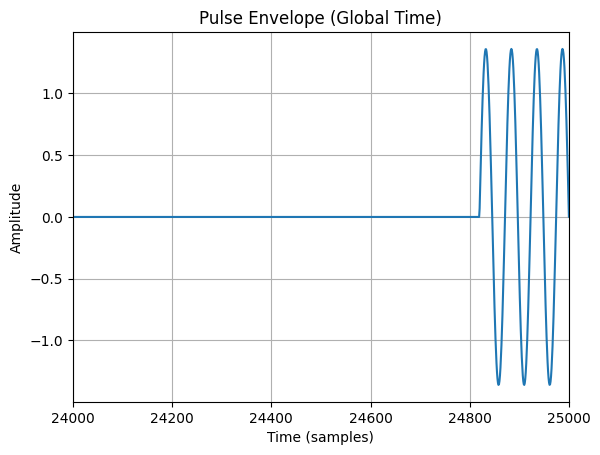

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 17.709220 sec
Captured 34 buffers (1.919904 buffers per sec)
Captured 104448 records (5897.944629 records per sec)
Transferred 1711276032 bytes (96631924.809697 bytes per sec)


In [16]:
reps = 2000
sweep_time = 250
swap_freq = -0.0194
swap_time =   0.5 * 7 / abs(swap_freq)
J = 10
num_steps = 51
tomography = "z"
y_ph = 77
df_prob, df_pop, values = run_rabi_tomo(
    q1=q1,
    q2=q2,
    general_vals_dict=general_vals_dict,
    num_steps=num_steps,
    sweep_time=sweep_time,
    swap_freq=swap_freq,
    swap_time=swap_time,
    reps=reps,
    tomography=tomography,
    J=J,
    y_ph=y_ph,
    x_tomo_ph=180
)

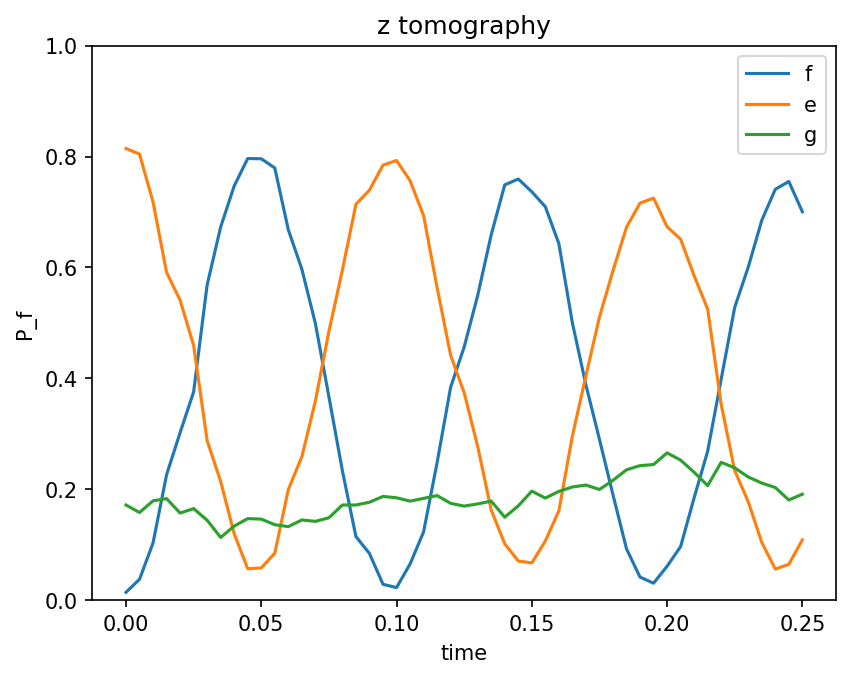

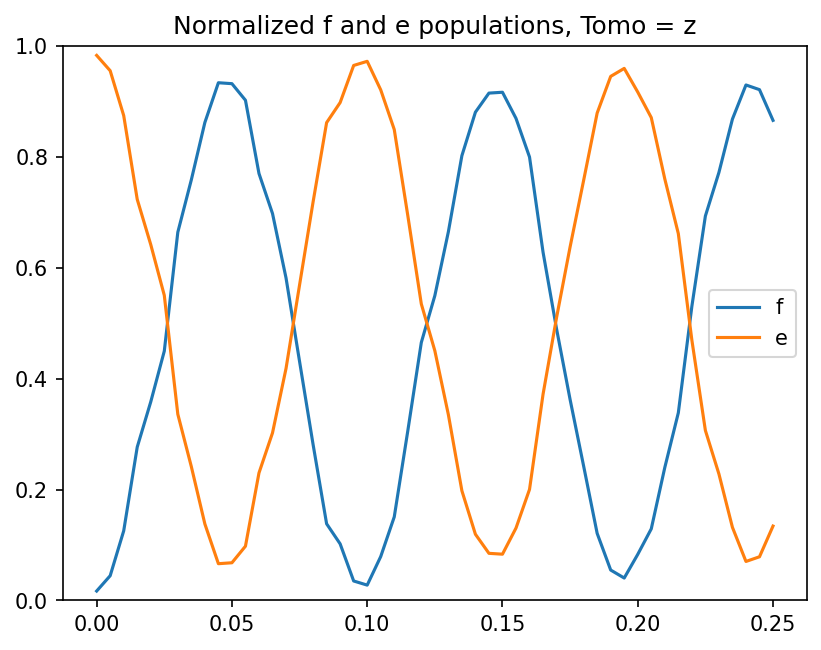

In [17]:
plt.figure(dpi=150)
sns.lineplot(data=df_prob, x="time", y="P_f", label="f")
sns.lineplot(data=df_prob, x="time", y="P_e", label="e")
sns.lineplot(data=df_prob, x="time", y="P_g", label="g")
plt.title(f"{tomography} tomography")
# plt.legend(
plt.ylim(0, 1)
plt.show()
plt.figure(dpi=150)
normalized_f = df_prob["P_f"] / (df_prob["P_f"] + df_prob["P_e"])
normalized_e = df_prob["P_e"] / (df_prob["P_f"] + df_prob["P_e"])
sns.lineplot(data=normalized_f, label="f")
sns.lineplot(data=normalized_e, label="e")
plt.title(f"Normalized f and e populations, Tomo = {tomography}")

plt.ylim(0, 1)
plt.legend()
plt.show()

In [18]:
normalized_e

0.000    0.983102
0.005    0.955463
0.010    0.874543
0.015    0.723378
0.020    0.641756
0.025    0.550299
0.030    0.335864
0.035    0.241263
0.040    0.137911
0.045    0.066237
0.050    0.067916
0.055    0.097801
0.060    0.229971
0.065    0.302162
0.070    0.418415
0.075    0.568996
0.080    0.718769
0.085    0.861798
0.090    0.897996
0.095    0.964945
0.100    0.972410
0.105    0.920876
0.110    0.849357
0.115    0.694393
0.120    0.534827
0.125    0.450331
0.130    0.335148
0.135    0.197809
0.140    0.119342
0.145    0.084940
0.150    0.083385
0.155    0.130515
0.160    0.200249
0.165    0.371859
0.170    0.510410
0.175    0.637726
0.180    0.757653
0.185    0.879085
0.190    0.945215
0.195    0.959629
0.200    0.916950
0.205    0.870903
0.210    0.760234
0.215    0.661626
0.220    0.469727
0.225    0.306632
0.230    0.228149
0.235    0.131812
0.240    0.070263
0.245    0.078707
0.250    0.134116
dtype: float64

In [7]:
# def run_rabi_x_tomo_swap_freq_sweep(freq_list, filename="rabi_x_tomo_swap_freq_sweep.pkl"):
#     """
#     Run a Rabi tomography sweep at different swap frequencies.
#     Save results to a file after each step. If the file already exists, restart from the last completed step.
#     """
#     reps = 2000
#     sweep_time = 0
#     num_steps = 51
#     tomography = 'x'
#     y_ph = 77

#     # Initialize arrays to store results
#     df_prob_list = []

#     # Check if the file exists
#     if os.path.exists(filename):
#         print(f"Loading existing data from {filename}...")
#         with open(filename, "rb") as f:
#             saved_data = pickle.load(f)

#         # Load saved data
#         df_prob_list = saved_data["df_prob_list"]
#         last_completed_step = saved_data["last_completed_step"]

#         print(f"Resuming from step {last_completed_step + 1}/{len(freq_list)}")
#     else:
#         last_completed_step = -1  # Start from the beginning

#     # Run the sweep
#     for i in range(last_completed_step + 1, len(freq_list)):
#         freq = freq_list[i]
#         swap_freq = freq
#         swap_time = 0.5 * 6 / abs(swap_freq)

#         # Perform Rabi tomography experiment
#         df_prob, df_pop, values = run_rabi_tomo(
#             q1=q1,
#             q2=q2,
#             general_vals_dict=general_vals_dict,
#             num_steps=num_steps,
#             sweep_time=sweep_time,
#             swap_freq=swap_freq,
#             swap_time=swap_time,
#             reps=reps,
#             tomography=tomography,
#             J=35,
#             y_ph=y_ph
#         )

#         # Store results
#         df_prob_list.append(df_prob)

#         # Save results to file after each step
#         with open(filename, "wb") as f:
#             pickle.dump(
#                 {
#                     "freq_list": freq_list,
#                     "df_prob_list": df_prob_list,
#                     "last_completed_step": i,  # Track the last completed step
#                 },
#                 f,
#             )

#         print(f"------------- Done with {i+1}/{len(freq_list)} --------------------")

#     return df_prob_list

In [8]:
# freq = -0.0195
# freq_diff = 0.003
# steps = 101
# freq_list = np.linspace(freq - freq_diff, freq + freq_diff, steps)
# df_prob_list = run_rabi_y_tomo_swap_freq_sweep(freq_list)

In [9]:
# import pickle
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit

# # Define the sine function for fitting
# def sine_function(x, A, phi, offset):
#     return A * np.sin(2 * np.pi * x + phi) + offset

# # Load the saved data
# filename = "rabi_y_tomo_swap_freq_sweep.pkl"
# with open(filename, "rb") as f:
#     saved_data = pickle.load(f)

# freq_list = saved_data["freq_list"]
# df_prob_list = saved_data["df_prob_list"]

# # Initialize a list to store y-amplitudes from sine fit
# y_amplitudes = []

# # Loop through each frequency and corresponding df_prob
# for freq, df_prob in zip(freq_list, df_prob_list):
#     # Extract time, P_f, and P_e
#     time = df_prob['time']
#     P_f = df_prob['P_f']
#     P_e = df_prob['P_e']

#     # Normalize P_f and P_e by dividing by (P_f + P_e)
#     epsilon = 1e-10  # Small value to avoid division by zero
#     P_f_normalized = P_f / (P_f + P_e + epsilon)
#     P_e_normalized = P_e / (P_f + P_e + epsilon)

#     # Fit P_f_normalized to a sine function
#     try:
#         popt, _ = curve_fit(sine_function, time, P_f_normalized, p0=[0.5, 0, 0.5])
#         amplitude = popt[0]  # Extract amplitude from the fit
#     except RuntimeError:
#         print(f"Failed to fit sine function for frequency = {freq:.6f}")
#         amplitude = np.nan  # Use NaN if fitting fails

#     # Store the y-amplitude
#     y_amplitudes.append(amplitude)

# # Plot frequency vs y-amplitude
# plt.figure(dpi=150)
# plt.plot(freq_list, y_amplitudes, 'o-', label='Y-Amplitude (Sine Fit)')
# plt.xlabel('Swap Frequency')
# plt.ylabel('Y-Amplitude')
# plt.axvline(-.0195, ls = 'dashed', color = 'red', label = 'Current Swap Frequency')
# plt.title('Frequency vs Y-Amplitude (Sine Fit)')
# plt.grid()
# plt.show()

In [10]:
# Define the list of y_ph values to sweep over
x_ph_list = np.linspace(165,195, 41)  # Example list, replace with your actual values

reps = 2000
sweep_time = 1
swap_freq = -0.0195
swap_time = 0.5 * 6 / abs(swap_freq)
J = 35
num_steps =1
tomography = "z"
y_ph = 77
# Define the folder to save results
save_folder = "x_ph_sweep"
os.makedirs(save_folder, exist_ok=True)

# Define a checkpoint file to track progress
checkpoint_file = os.path.join(save_folder, "checkpoint.txt")

# Load the last completed y_ph value if the checkpoint file exists
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, "r") as f:
        last_completed_x_ph = float(f.read().strip())
else:
    last_completed_x_ph = None

# Loop over the y_ph values
for x_ph in x_ph_list:
    # Skip already completed y_ph values
    if last_completed_x_ph is not None and x_ph <= last_completed_x_ph:
        print(f"Skipping x_ph = {x_ph} (already completed)")
        continue

    print(f"Running for x_ph = {x_ph}")

    # Run the Rabi tomography simulation
    df_prob, df_pop, values = run_rabi_tomo(
        q1=q1,
        q2=q2,
        general_vals_dict=general_vals_dict,
        num_steps=num_steps,
        sweep_time=sweep_time,
        swap_freq=swap_freq,
        swap_time=swap_time,
        reps=reps,
        tomography=tomography,
        J=J,
        y_ph=y_ph,
        x_tomo_ph= x_ph
    )

    # Save the df_prob dataframe
    save_filename = os.path.join(save_folder, f"df_prob_x_ph_{x_ph}.csv")
    df_prob.to_csv(save_filename, index=False)
    print(f"Saved results for x_ph = {x_ph} to {save_filename}")

    # Update the checkpoint file
    with open(checkpoint_file, "w") as f:
        f.write(str(x_ph))
    print(f"Updated checkpoint to x_ph = {x_ph}")

print("Sweep complete!")

Skipping x_ph = 165.0 (already completed)
Skipping x_ph = 165.75 (already completed)
Skipping x_ph = 166.5 (already completed)
Skipping x_ph = 167.25 (already completed)
Skipping x_ph = 168.0 (already completed)
Skipping x_ph = 168.75 (already completed)
Skipping x_ph = 169.5 (already completed)
Skipping x_ph = 170.25 (already completed)
Skipping x_ph = 171.0 (already completed)
Skipping x_ph = 171.75 (already completed)
Skipping x_ph = 172.5 (already completed)
Skipping x_ph = 173.25 (already completed)
Skipping x_ph = 174.0 (already completed)
Skipping x_ph = 174.75 (already completed)
Skipping x_ph = 175.5 (already completed)
Skipping x_ph = 176.25 (already completed)
Skipping x_ph = 177.0 (already completed)
Skipping x_ph = 177.75 (already completed)
Skipping x_ph = 178.5 (already completed)
Skipping x_ph = 179.25 (already completed)
Skipping x_ph = 180.0 (already completed)
Skipping x_ph = 180.75 (already completed)
Skipping x_ph = 181.5 (already completed)
Skipping x_ph = 182.25 

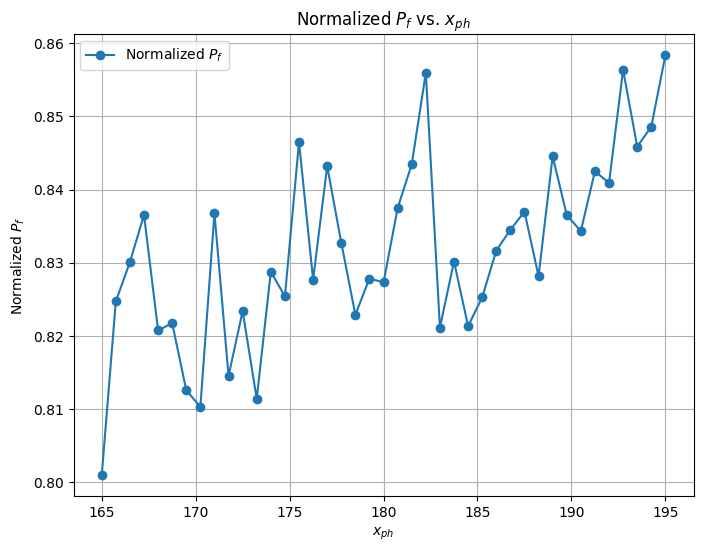

In [11]:
import glob
# Folder where your CSV files are saved
save_folder = "x_ph_sweep"

# Use glob to get all CSV files matching the pattern
csv_files = glob.glob(os.path.join(save_folder, "df_prob_x_ph_*.csv"))

x_ph_values = []
norm_pf_values = []

# Loop over each CSV file
for file in csv_files:
    # Extract the x_ph value from the filename.
    # Assuming the filename format is: "df_prob_x_ph_{x_ph}.csv"
    basename = os.path.basename(file)
    # Remove the prefix and suffix to get the numeric part
    # E.g., from "df_prob_x_ph_180.0.csv" extract "180.0"
    x_ph_str = basename.replace("df_prob_x_ph_", "").replace(".csv", "")
    x_ph_val = float(x_ph_str)
    
    # Load the CSV file into a DataFrame
    df_prob = pd.read_csv(file)
    
    # Calculate the normalized P_f = P_f / (P_f + P_e)
    # Assuming there's one row in the DataFrame
    P_f = df_prob["P_f"].iloc[0]
    P_e = df_prob["P_e"].iloc[0]
    norm_pf = P_f / (P_f + P_e)
    
    # Store the values
    x_ph_values.append(x_ph_val)
    norm_pf_values.append(norm_pf)

# Sort the data by x_ph values (important for plotting a smooth curve)
sorted_indices = sorted(range(len(x_ph_values)), key=lambda i: x_ph_values[i])
x_ph_sorted = [x_ph_values[i] for i in sorted_indices]
norm_pf_sorted = [norm_pf_values[i] for i in sorted_indices]

# Plot normalized P_f versus x_ph
plt.figure(figsize=(8, 6))
plt.plot(x_ph_sorted, norm_pf_sorted, 'o-', label="Normalized $P_f$")
plt.xlabel("$x_{ph}$")
plt.ylabel("Normalized $P_f$")
plt.title("Normalized $P_f$ vs. $x_{ph}$")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
from scipy.optimize import curve_fit
import analysis.fit_functions as fit_funcs  # This package should contain sine_decay

# Extract the time values from df_prob
time = df_prob["time"].values

# Compute normalized populations: P_f_norm and P_e_norm
normalized_f = df_prob["P_f"] / (df_prob["P_f"] + df_prob["P_e"])
normalized_e = df_prob["P_e"] / (df_prob["P_f"] + df_prob["P_e"])

# Define an initial guess for the sine_decay parameters:
# Parameters: freq_Hz, gamma, amplitude, phase_deg, offset
initial_guess_e = [1.0, 0.1, 0.5, 0.0, 0.1]
initial_guess_f = [1.0, 0.1, 0.5, 180, 0.1]

# Perform curve fit for normalized f data
popt_f, pcov_f = curve_fit(fit_funcs.sine_decay, time, normalized_f.values, p0=initial_guess_f)
# Compute the fitted curve for normalized f
fitted_f = fit_funcs.sine_decay(time, *popt_f)

# Perform curve fit for normalized e data
popt_e, pcov_e = curve_fit(fit_funcs.sine_decay, time, normalized_e.values, p0=initial_guess_e)
# Compute the fitted curve for normalized e
fitted_e = fit_funcs.sine_decay(time, *popt_e)

# Plot the data and the fitted curves
plt.figure(dpi=150)
sns.lineplot(x=time, y=normalized_f, label="Normalized f (data)")
sns.lineplot(x=time, y=fitted_f, label="Normalized f (fit)", linestyle="--")
sns.lineplot(x=time, y=normalized_e, label="Normalized e (data)")
sns.lineplot(x=time, y=fitted_e, label="Normalized e (fit)", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Normalized Population")
plt.title(f"Normalized f and e populations, Tomo = {tomography}")
plt.legend()
plt.grid(True)
plt.show()

# Optionally, print the fitted parameters
print("Fitted parameters for normalized f:")
print(" freq_Hz =", popt_f[0])
print(" gamma   =", popt_f[1])
print(" amplitude =", popt_f[2])
print(" phase_deg =", popt_f[3])
print(" offset  =", popt_f[4])
print("\nFitted parameters for normalized e:")
print(" freq_Hz =", popt_e[0])
print(" gamma   =", popt_e[1])
print(" amplitude =", popt_e[2])
print(" phase_deg =", popt_e[3])
print(" offset  =", popt_e[4])

TypeError: Improper input: func input vector length N=5 must not exceed func output vector length M=1